In [1]:
import numpy as np
import pandas as pd
import cv2
import mahotas
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

# General Functions

In [4]:
# parameters for the features extraction
bins = 8

# functions to extract features from the images
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def create_features(imgs, data_path='data-challenge/Train/'):
    # Compute the features
    feat_haralick = []
    feat_histogram = []
    feat_hu = []
    print(data_path)
    for i in imgs:
        img = cv2.imread(data_path + i)  # Load image
        feat_hu.append(fd_hu_moments(img))  # Append Hu values
        feat_haralick.append(fd_haralick(img))  # Append Haralick values
        feat_histogram.append(fd_histogram(img))  # Append Histogram values
    
    df_features = np.hstack([feat_haralick, feat_hu, feat_histogram])
    df_features = pd.DataFrame(df_features)
    print(df_features.shape)

    return df_features

def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

def parseTest_fn(filename):
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

def create_split(images_train, images_test, train_path, test_path):
    columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

    df = pd.DataFrame(list(map(parse_fn, images_train)), columns=columns)
    label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
    df['type_id'] = df['type'].apply(lambda x: label_maps[x])
    
    df_features = create_features(images_train, train_path)
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['type_id'], stratify=df['type_id'], test_size=0.2)

    columns = ['procedure', 'id', 'filename']
    info_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
    df_features_test = create_features(info_test['filename'], test_path)

    return X_train, X_val, y_train, y_val, df_features_test, info_test

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(accuracy_score(y_val,y_pred))
    print(classification_report(y_val, y_pred))
    print(f1_score(y_val, y_pred, average='macro'))
    return y_pred

def create_submission(model, X_test, info_test):
    y_pred_test = model.predict(X_test)
    df_pred = pd.concat([info_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)

    display(df_pred['type_id'].value_counts())
    df_pred.to_csv('my_pred.csv', index=False, header=False)

# Data Pre-processing

In [5]:
train_path = 'data-challenge/Train/'
test_path = 'data-challenge/Test/'
images_train = os.listdir(path=train_path)
images_test = os.listdir(path=test_path)

X_train, X_val, y_train, y_val, df_features_test, info_test = create_split(images_train, images_test, train_path, test_path)

data-challenge/Train/
(422, 532)
data-challenge/Test/
(207, 532)


# Best configuration

Voici la meilleur configuration obtenue. Je l'ai obtenue assez rapidement. Ce modele sklearn est une implémentation de lightGBM, un algorithme de boosting plus légère et efficace que les autres methodes de boosting en utilisant un algorithme basé sur un histogramme de valeurs.

Le parametre le plus influents semblait etre min_sample_leaf. Cette valeur est assez élevé et permet de limiter la compléxité des modeles en limitant le nombre de feuilles par arbre. J'ai par la suite tenté d'améliorer les resultats en touchant à ce paramètre, ou à la régularisation L2 afin de limiter encore plus l'overfitting mais cela n'a fait que dégrader les performances. La max depth à aussi été tune. La valeur 7 semblait etre un bon compromis. Une valeur moins élevé réduisait les performances du modèle tandis qu'une valeur plus élevé favorisait l'overfitting.

Il est assez étonnant que ce modèle soit le plus performant pour ces données. La doc sklearn mentionne que celui-ci est particulièrement efficace pour les gros datasets, or ce n'est pas notre cas ici. Une autre source [kaggle](https://www.kaggle.com/general/264327) annonce que light gbm à tendance à overfit les petits datasets. Malgré tout, c'est le meilleur modèle que j'ai pu obtenir parmis les autres algorithmes de boosting de gradient.

Je n'ai pas fait de recherches de paramêtres avec un grid search car les modèles avait tendance à très vite overfitter. Je me retrouvais parfois avec de très bons F1 score sur le jeu de test mais une fois la prediction soumise, le F1 score etait très mauvais. J'y suis donc allé à taton en verifiant à chaque fois le score lors de la soumission. Ce qui explique mon nombre de soumissions très élevé.

In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier
# best config : 0.7127 model_hgb = HistGradientBoostingClassifier(max_iter=1000, learning_rate=0.1,min_samples_leaf=20, l2_regularization=0, max_depth=7, random_state=1)
model_hgb = HistGradientBoostingClassifier(max_iter=1000, learning_rate=0.1,min_samples_leaf=20, l2_regularization=0, max_depth=7, random_state=1)
model_hgb.fit(X_train, y_train)
evaluate_model(model_hgb, X_val, y_val)

create_submission(model_hgb, df_features_test, info_test)

0.8588235294117647
              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       1.00      0.89      0.94         9
           3       0.82      0.95      0.88        19
           4       0.90      0.82      0.86        11
           5       1.00      0.75      0.86        12
           6       1.00      0.67      0.80         3
           7       0.75      0.92      0.83        13
           8       0.60      1.00      0.75         3

    accuracy                           0.86        85
   macro avg       0.87      0.85      0.85        85
weighted avg       0.88      0.86      0.86        85

0.8460300036751454


7    66
2    48
3    34
1    23
4    22
5    13
8     1
Name: type_id, dtype: int64

# Autres pistes explorées

Boosting, SVM, SGD, Transfert Learning, Data augmentation

Beaucoup d'efforts ont été fournit dans les algorithmes de boosting. Ces derniers ont été les second algorithmes à être testés après le random forest et se sont révelés assez performants. J'ai donc essayé les gradient boosting de base de Sklearn mais aussi XGBoost. Sans succès. J'ai ensuite testé un SVM avec un kernel rbf et un grand grid search sur les parametres C et gamma qui semblait etre les parametres les plus important pour ce kernel. 

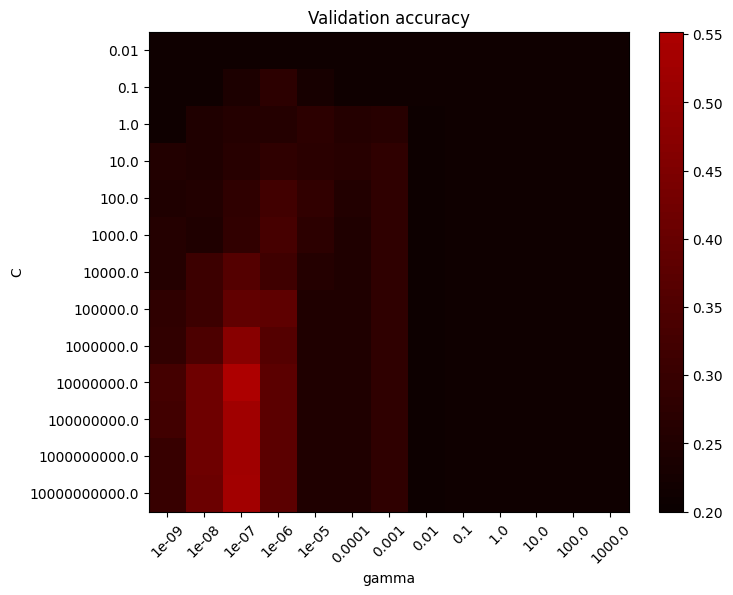

In [ ]:
# le code ne marche pas, il est issue de mon autre notebook, il est juste la pour illustrer le grid search sur les parametres
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

Le grid search pour le SVM privilegiait des valeurs extremes pour C et gamma pour atteindre un score plutot mauvais (autour des 0.6). La piste des SVM à donc été abandonné.

La dernière piste beaucoup explorée fut le transfert learning. Le principe est  de prendre un modele de classification d'image pré entrainer et de l'utiliser afin de classifier les images de notre dataset. Le choix du modele s'est porté sur MobileNetV3 pour son efficacité mémoire et de prédiction. Utilisant mon ordinateur portable, je ne pouvais pas me permettre d'utiliser un gros modele. Les poids d'initialisation utilisés étaient les poids Imagenet, un des plus gros dataset de classification d'images. Enfin, la couche de prédiction initiale du modele à été remplacée par mon propre sous modele. Celui-ci etait composé d'une couche GlobalAveragePooling2D afin de récuperer un vecteur, puis d'une combinaison de couche dense de taille variable selon les essais. La couche de sortie est une couche dense de taille 8 pour faire de la classification avec une couche d'activation softmax.
Bien que vite performant, le transfert learning ne m'a pas permit de dépassé mon meilleur score. Une pipeline d'augmentation de données à aussi été mis en place pour lutter contre le manque de donnée mais cela n'a pas suffit.

# Perspective d'amélioration

Durant ce projet, je n'ai pas retravailler les features par manque (ou mauvaise gestion) de temps. J'aurais aimé essayer d'autres features ou encore faire une PCA. J'aurais aimé aussi prendre la sortie d'une couche intermédiaire d'un réseau pré entrainé et l'utiliser comme nouveau vecteur de feauture dans un modele de ML comme un SVM ou un gradient boosting.